<a href="https://colab.research.google.com/github/jathinlohi/BERT-Playlist-for-Spotify/blob/main/BERT_for_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets scikit-learn pandas torch tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!mkdir data

In [3]:
!mkdir utils

In [4]:
!mkdir model

In [5]:
from utils import save_dataset
save_dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

<module 'utils.save_dataset' from '/content/utils/save_dataset.py'>

In [6]:
from utils import label_map
label_map

<module 'utils.label_map' from '/content/utils/label_map.py'>

In [8]:
from utils import data_preprocessing
data_preprocessing

<module 'utils.data_preprocessing' from '/content/utils/data_preprocessing.py'>

In [9]:
from model import emotion_classifier
emotion_classifier

<module 'model.emotion_classifier' from '/content/model/emotion_classifier.py'>

In [10]:
from transformers import BertTokenizer
from utils.data_preprocessing import get_dataloaders

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_loader, val_loader = get_dataloaders(tokenizer)

# Quick check
for batch in train_loader:
    print(batch["input_ids"].shape)       # [batch_size, seq_len]
    print(batch["labels"].shape)          # [batch_size, num_emotions]
    break

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

torch.Size([16, 128])
torch.Size([16, 28])


In [11]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import get_scheduler
from sklearn.metrics import f1_score, accuracy_score

from model.emotion_classifier import EmotionClassifier
from utils.data_preprocessing import GoEmotionsDataset

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 3
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_CLASSES = 28

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = GoEmotionsDataset("data/goemotions_train.csv",tokenizer=tokenizer)
val_dataset = GoEmotionsDataset("data/goemotions_val.csv",tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [14]:
model = EmotionClassifier(num_classes=NUM_CLASSES).to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=len(train_loader) * EPOCHS)

criterion = nn.BCELoss()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
from tqdm import tqdm

def train_epoch(model, train_loader, optimizer, criterion, scheduler=None):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc="🧠 Training", leave=False)

    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        total_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    return total_loss / len(train_loader)


def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()

            outputs = model(input_ids, attention_mask)
            preds = outputs.cpu().numpy()

            # Apply threshold
            preds = (preds >= 0.5).astype(int)

            all_preds.extend(preds)
            all_labels.extend(labels)

    f1 = f1_score(all_labels, all_preds, average="micro")
    acc = accuracy_score(all_labels, all_preds)
    return f1, acc


In [16]:
for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")

    train_loss = train_epoch(model, train_loader, optimizer, criterion, lr_scheduler)
    f1, acc = evaluate(model, val_loader)

    print(f"📉 Loss: {train_loss:.4f} | 🎯 F1: {f1:.4f} | ✅ Accuracy: {acc:.4f}")



🚀 Epoch 1/3


📉 Loss: 0.1302 | 🎯 F1: 0.4947 | ✅ Accuracy: 0.3647

🚀 Epoch 2/3


📉 Loss: 0.0883 | 🎯 F1: 0.5562 | ✅ Accuracy: 0.4403

🚀 Epoch 3/3


📉 Loss: 0.0770 | 🎯 F1: 0.5674 | ✅ Accuracy: 0.4512


In [20]:
import torch

# Save the model (state_dict)
torch.save(model.state_dict(), "emotion_classifier.pt")
print("🧠 Model saved as emotion_classifier.pt")


🧠 Model saved as emotion_classifier.pt


In [17]:
from google.colab import drive
drive.mount('/content/drive')

# Save to a specific path in your Google Drive
save_path = "/content/drive/MyDrive/emotion_classifier.pt"
torch.save(model.state_dict(), save_path)
print(f"🧠 Model saved to Google Drive at: {save_path}")


Mounted at /content/drive
🧠 Model saved to Google Drive at: /content/drive/MyDrive/emotion_classifier.pt


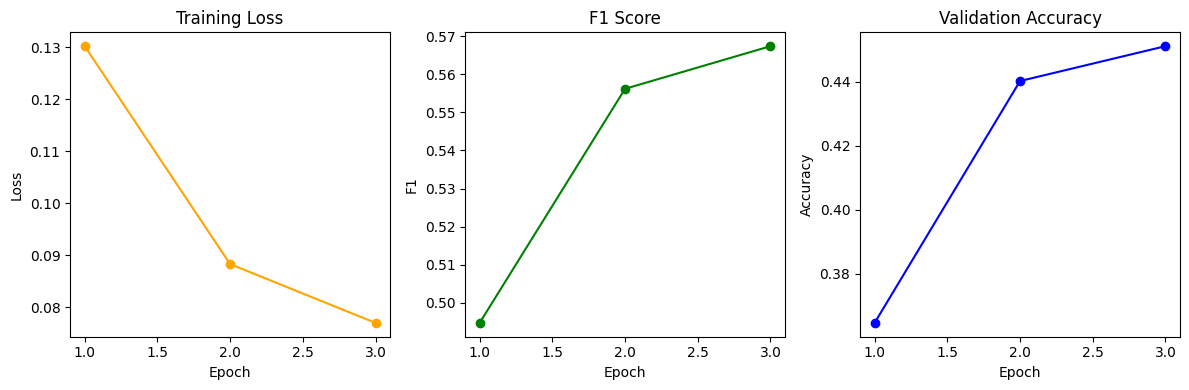

In [18]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
train_losses = [0.1302, 0.0883, 0.0770]
f1_scores = [0.4947, 0.5562, 0.5674]
accuracies = [0.3647, 0.4403, 0.4512]

plt.figure(figsize=(12, 4))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o', color='orange')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# F1 Score Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, f1_scores, marker='o', color='green')
plt.title("F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1")

# Accuracy Plot
plt.subplot(1, 3, 3)
plt.plot(epochs, accuracies, marker='o', color='blue')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [21]:
import zipfile
from google.colab import files

model_file = "emotion_classifier.pt"
zip_filename = "emotion_model.zip"

# Zip it
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    zipf.write(model_file)

print("Model zipped successfully!")

# Download it
files.download(zip_filename)



Model zipped successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>